In [157]:
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import potential
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)


import JaxCoords as jc

In this example we will integrate orbits in a custom time-dependent potential function. 
All we need to supply is the potential: Jax will take care of its derivatives via automatic differentiation.


The potential function we will define is a time-dependent NFW

$$\Phi_{\rm osc}\left(\mathbf{r}, t\right) = -\frac{G M(t)}{r} \ln{\left(1 + \frac{r}{r_s(t)}\right)}$$
with the functions
$$M(t) = M_{\rm base} + M_{\rm osc}\sin\left(\Omega t\right)$$
$$r_s(t) = r_{s,\rm base} + r_{s, \rm osc}\sin\left(\Omega t\right)$$


In [158]:
from potential import CustomPotential

In [159]:
from astropy.constants import G
## Define the grav. constant in the simulation unit system [kpc, Myr, Msun]
G_ = G.decompose(usys).value
M_base = 1e12 #Msun
M_osc = 5e11
rs_base = 15.0 #kpc
rs_osc = 10.0
T = 500.0 #Myr
omega = 2*jnp.pi / T


@jax.jit
def osc_potential_func(xyz, t):
    r = jnp.sqrt(jnp.sum(xyz**2))
    curr_mass = M_base + M_osc*jnp.sin(omega*t)
    rs_curr = rs_base + rs_osc*jnp.sin(omega*t)
    return - (G_*curr_mass / r)*jnp.log(1 + r/rs_curr)

@jax.jit
def static_potential_func(xyz, t):
    r = jnp.sqrt(jnp.sum(xyz**2))
    curr_mass = M_base 
    rs_curr = rs_base 
    return - (G_*curr_mass / r)*jnp.log(1 + r/rs_curr)

In [160]:
pot_osc = CustomPotential(potential_func=osc_potential_func, units=usys)
pot_static = CustomPotential(potential_func=static_potential_func, units=usys)

In [161]:
w0 = jnp.array([10.0, 10.0, 15.0, 0.1, 0.2, 0.1])
ts = jnp.linspace(-4000,0,1000)
orb_osc = pot_osc.integrate_orbit(w0=w0,ts=ts).ys
orb_static = pot_static.integrate_orbit(w0=w0,ts=ts).ys

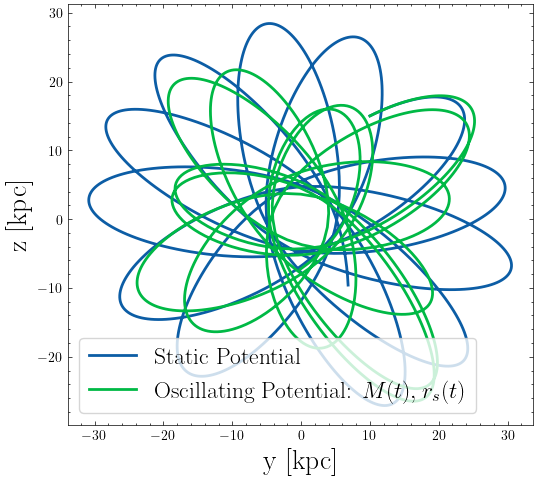

In [171]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
ax.plot(orb_static[:,1],orb_static[:,2], label='Static Potential',lw=2)
ax.plot(orb_osc[:,1],orb_osc[:,2],label=r'Oscillating Potential: $M(t), r_s(t)$',lw=2)

ax.legend(fontsize=17,loc='lower left',frameon=True)
ax.set_xlabel('y [kpc]', fontsize=20)
ax.set_ylabel('z [kpc]', fontsize=20)

ax.set_aspect('equal')
